In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
from PIL import Image
import torch
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import compute_roc_auc
from monai.networks.nets import densenet121, densenet201
from monai.transforms import (
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor
)
from monai.utils import set_determinism

#from data_split import data_separator, get_oversampling
#from data_loader import load_and_preprocess_image, generate_path_dataset, augmenter
#from model_creation import start_model, set_check_poin_saver, set_check_point_saver_regression
#from model_evaluation import plot_model_history, get_dataset_prediction, evaluate_prediction

2024-03-08 21:13:29.904972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 21:13:30.066087: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 21:13:30.697297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/12559743/.local/lib/python3.10/site-packages/cv2/../../lib64::/opt/Qt/6.3.1/gcc_6/lib
2024-03-08 21:13:30.697442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynam

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


# Reading Dataset

In [3]:
df = pd.read_csv("/home/12559743/DAVI/IC/Codes/data_aug.csv")
print(len(df))

1455


In [4]:
print(df.iloc[1430]['Patient'], df.iloc[1430]['PAN Date'], df.iloc[1430]['PAN Path'])

nan nan /home/12559743/DAVI/todos_pacientes/ZILDA SCHIAVON CAMILLO/ZILDA SCHIAVON CAMILLO- -- - - - 15-09-1961- PX from 29-02-2016 S0 I0aug_cr.jpg


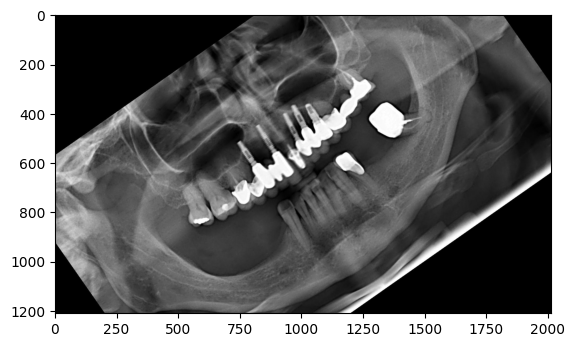

In [5]:
img = plt.imread(df.iloc[1450]['PAN Path'])
plt.imshow(img)

# Pre-Processing images

In [6]:
from sklearn.model_selection import train_test_split as splitter
import random

def data_separator(data, train_rate=0.70, val_rate=0.50, SEED=42):
    
    '''
        Applies train, val, test split.
    '''
    
    # Separando train, val and test IMAGE path list
    
    if not val_rate:
        train, test = splitter(data, test_size= 1-train_rate, shuffle=True, random_state=SEED)
        
        return train, test
        
    elif val_rate:
        train, test = splitter(data, test_size= 1-train_rate, shuffle=True, random_state=SEED)
        
        val, test = splitter(test, test_size= 1-val_rate, shuffle=True, random_state=SEED)

        return train, val, test 



In [7]:
train, val, test = data_separator(df, train_rate=.8, val_rate=.5)
    
print(len(train), len(val), len(test))

1164 145 146


In [8]:
train_list = (list(train['PAN Path']), list(train['Sex']))
val_list = (list(val['PAN Path']), list(val['Sex']))
test_list = (list(test['PAN Path']), list(test['Sex']))

print(len(train), len(val), len(test))

1164 145 146


In [9]:
image_list_train =[]
image_list_train_y = []

for i in range(len(train)):
    #print(i)
    x = cv2.imread(train_list[0][i])
    x = cv2.resize(x, (224, 224))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    image_list_train.append(x)
    image_list_train_y.append(train_list[1][i])
    
image_list_val = []
image_list_val_y = []

for i in range(len(val)):
    #print(i)
    x = cv2.imread(val_list[0][i])
    x = cv2.resize(x, (224, 224))
    X = cv2.cvtColor(x,  cv2.COLOR_BGR2RGB)
    image_list_val.append(x)
    image_list_val_y.append(val_list[1][i])
    
    
    
image_list_test = []
image_list_test_y = []

for i in range(len(test)):
    #print(i)
    x = cv2.imread(test_list[0][i])
    x = cv2.resize(x, (224, 224))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    image_list_test.append(x)
    image_list_test_y.append(test_list[1][i])

## Realizing a tensor transforming

In [21]:
from torch.utils.data import Dataset
import torchvision.transforms as T
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Verifica se a imagem é um tensor
        if not isinstance(image, torch.Tensor):
        # Carrega a imagem do diretório usando PIL
            image = Image.open(image).convert('RGB')
    
        if self.transform:
            image = self.transform(image)
    
        return image, label

#construindo minha função de transformação

normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
transform = T.Compose([
    T.ToTensor(),
    normalize
])



In [11]:
'''#transformando as imagens em tensores
image_list_train = torch.tensor(image_list_train)
image_list_train_y = torch.tensor(image_list_train_y)
image_list_val = torch.tensor(image_list_val)
image_list_val_y = torch.tensor(image_list_val_y)
image_list_test = torch.tensor(image_list_test)
image_list_test_y = torch.tensor(image_list_test_y)
'''

##fazer upload do diretorio e testar
train_dataset = CustomDataset(image_list_train, image_list_train_y)
val_dataset = CustomDataset(image_list_val, image_list_val_y)
test_dataset = CustomDataset(image_list_test, image_list_test_y)


Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)


In [18]:
train_dataset.transform = transform
val_dataset.transform = transform
test_dataset.transform = transform

In [19]:
categories = ['0', '1']

def look_dataset(dataset, istensor=False):
    figure = plt.figure(figsize=(8,8))
    rows, cols = 2,2
    for i in range(1,5):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(categories[label])
        plt.axis('off')
        if istensor:
            plt.imshow(img.squeeze().permute(1,2,0))
        else:
            plt.imshow(img)
    plt.show()

In [22]:
look_dataset(train_dataset)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

<Figure size 800x800 with 0 Axes>